In [19]:
%matplotlib inline

import os,sys,inspect

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

Trasformato il problema in binario:
- 1 attività dinamiche = 1,2,3
    - 1 WALKING
    - 2 WALKING_UPSTAIRS
    - 3 WALKING_DOWNSTAIRS
- 0 attività statiche = 4,5,6
    - 4 SITTING
    - 5 STANDING
    - 6 LAYING


In [2]:
X_train = pd.read_csv('Dataset/train/Inertial Signals/body_acc_x_train.txt', header=None, delim_whitespace=True)
#X_train['subject'] = pd.read_csv('Dataset/train/subject_train.txt', header=None)
y_train = pd.read_csv('Dataset/train/y_train.txt', header = None, names = ['Activity'])

y_train.loc[y_train.Activity <4, 'Activity'] = 1 #1,2,3 Dinamiche
y_train.loc[y_train.Activity >3, 'Activity'] = 0 #4,5,6 Statiche
print(f"Number of time series: {X_train.shape[0]}\nLength: {X_train.shape[1]}")


Number of time series: 7352
Length: 128


In [3]:
X_test = pd.read_csv('Dataset/test/Inertial Signals/body_acc_x_test.txt', header=None, delim_whitespace=True)
#X_train['subject'] = pd.read_csv('Dataset/train/subject_train.txt', header=None)
y_test = pd.read_csv('Dataset/test/y_test.txt', header = None, names = ['Activity'])

y_test.loc[y_test.Activity <4, 'Activity'] = 1 #1,2,3 Dinamiche
y_test.loc[y_test.Activity >3, 'Activity'] = 0 #4,5,6 Statiche
print(f"Number of time series: {X_test.shape[0]}\nLength: {X_test.shape[1]}")


Number of time series: 2947
Length: 128


# Preprocessing

Trasformazione del dataset attraverso amplitude

In [4]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
X_train = scaler.fit_transform(X_train)
X_train = X_train.squeeze()

In [5]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
X_test = scaler.fit_transform(X_test)
X_test = X_test.squeeze()

In [6]:
X_train.shape, X_test.shape

((7352, 128), (2947, 128))

# Shapelets

In [7]:
#from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

In [8]:
help(grabocka_params_to_shapelet_size_dict)

Help on function grabocka_params_to_shapelet_size_dict in module tslearn.shapelets.shapelets:

grabocka_params_to_shapelet_size_dict(n_ts, ts_sz, n_classes, l, r)
    Compute number and length of shapelets.
    
     This function uses the heuristic from [1]_.
    
    Parameters
    ----------
    n_ts: int
        Number of time series in the dataset
    ts_sz: int
        Length of time series in the dataset
    n_classes: int
        Number of classes in the dataset
    l: float
        Fraction of the length of time series to be used for base shapelet
        length
    r: int
        Number of different shapelet lengths to use
    
    Returns
    -------
    dict
        Dictionary giving, for each shapelet length, the number of such
        shapelets to be generated
    
    Examples
    --------
    >>> d = grabocka_params_to_shapelet_size_dict(
    ...         n_ts=100, ts_sz=100, n_classes=3, l=0.1, r=2)
    >>> keys = sorted(d.keys())
    >>> print(keys)
    [10, 20]
    >>

Necessario testare differenti forme per gli shapelets:
l = 0.1, 0.01, 0.05, 0.01
- i migliori sono risultati essere 0.1 e 0.08:
    - 0.1: shapelet_sizes  {12: 5}
    - 0.08: shapelet_sizes  {10: 5}

**Il migliore sulla base dell'accuracy ottenuta è l = 0.1**

### Shapelet migliore l = 0.1

In [9]:
n_ts, ts_sz = X_train.shape
n_classes = len(set(y_train.Activity))

# Set the number of shapelets per size as done in the original paper
# Compute number and length of shapelets.
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts, # numero di TS nel dataset
                                                       ts_sz=ts_sz, #lunghezza delle TS nel dataset
                                                       n_classes=n_classes, # numero di classi
                                                       l=0.1, # frazione della lunghezza delle TS da utilizzare come base per il shapelet length
                                                       r=1) # numero di differenti shapelet length da utilizzare

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 7352
ts_sz 128
n_classes 2
shapelet_sizes {12: 5}


In [10]:
# Define the model using parameters provided by the authors 
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        #optimizer=tf.optimizers.Adam(.01), # si usa il default sgd
                        weight_regularizer=.01,
                        max_iter=1500,
                        verbose=1)

In [11]:
shp_clf.fit(X_train, y_train)

Epoch 1/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.7087 - binary_accuracy: 0.4861 - binary_crossentropy: 0.6815
Epoch 2/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.7070 - binary_accuracy: 0.4879 - binary_crossentropy: 0.6800
Epoch 3/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.7054 - binary_accuracy: 0.4912 - binary_crossentropy: 0.6787
Epoch 4/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.7038 - binary_accuracy: 0.4963 - binary_crossentropy: 0.6774
Epoch 5/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.7024 - binary_accuracy: 0.5010 - binary_crossentropy: 0.6762
Epoch 6/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.7010 - binary_accuracy: 0.5060 - binary_crossentropy: 0.6750
Epoch 7/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6996 - binary_accuracy: 0.5109 - binary_crossentropy: 0.6739
Epoch 8/1500
29/29 [=====================

29/29 [==============================] - 0s 4ms/step - loss: 0.6295 - binary_accuracy: 0.7418 - binary_crossentropy: 0.6039
Epoch 120/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6290 - binary_accuracy: 0.7435 - binary_crossentropy: 0.6033
Epoch 121/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6285 - binary_accuracy: 0.7476 - binary_crossentropy: 0.6027
Epoch 122/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6280 - binary_accuracy: 0.7488 - binary_crossentropy: 0.6021
Epoch 123/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6275 - binary_accuracy: 0.7510 - binary_crossentropy: 0.6014
Epoch 124/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6269 - binary_accuracy: 0.7554 - binary_crossentropy: 0.6008
Epoch 125/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6264 - binary_accuracy: 0.7578 - binary_crossentropy: 0.6001
Epoch 126/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.5943 - binary_accuracy: 0.8500 - binary_crossentropy: 0.5594
Epoch 179/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5936 - binary_accuracy: 0.8520 - binary_crossentropy: 0.5585
Epoch 180/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5929 - binary_accuracy: 0.8523 - binary_crossentropy: 0.5576
Epoch 181/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5921 - binary_accuracy: 0.8553 - binary_crossentropy: 0.5567
Epoch 182/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5914 - binary_accuracy: 0.8558 - binary_crossentropy: 0.5557
Epoch 183/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5906 - binary_accuracy: 0.8572 - binary_crossentropy: 0.5548
Epoch 184/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5899 - binary_accuracy: 0.8588 - binary_crossentropy: 0.5538
Epoch 185/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.5451 - binary_accuracy: 0.9066 - binary_crossentropy: 0.4972
Epoch 238/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5442 - binary_accuracy: 0.9070 - binary_crossentropy: 0.4961
Epoch 239/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5434 - binary_accuracy: 0.9078 - binary_crossentropy: 0.4950
Epoch 240/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5425 - binary_accuracy: 0.9081 - binary_crossentropy: 0.4939
Epoch 241/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5416 - binary_accuracy: 0.9086 - binary_crossentropy: 0.4928
Epoch 242/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5407 - binary_accuracy: 0.9089 - binary_crossentropy: 0.4917
Epoch 243/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5399 - binary_accuracy: 0.9093 - binary_crossentropy: 0.4906
Epoch 244/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4967 - binary_accuracy: 0.9192 - binary_crossentropy: 0.4360
Epoch 297/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4960 - binary_accuracy: 0.9189 - binary_crossentropy: 0.4351
Epoch 298/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4953 - binary_accuracy: 0.9192 - binary_crossentropy: 0.4342
Epoch 299/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4946 - binary_accuracy: 0.9193 - binary_crossentropy: 0.4334
Epoch 300/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4939 - binary_accuracy: 0.9195 - binary_crossentropy: 0.4325
Epoch 301/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4933 - binary_accuracy: 0.9196 - binary_crossentropy: 0.4316
Epoch 302/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4926 - binary_accuracy: 0.9199 - binary_crossentropy: 0.4308
Epoch 303/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4644 - binary_accuracy: 0.9212 - binary_crossentropy: 0.3950
Epoch 356/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4640 - binary_accuracy: 0.9210 - binary_crossentropy: 0.3945
Epoch 357/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4636 - binary_accuracy: 0.9210 - binary_crossentropy: 0.3940
Epoch 358/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4632 - binary_accuracy: 0.9210 - binary_crossentropy: 0.3935
Epoch 359/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4628 - binary_accuracy: 0.9210 - binary_crossentropy: 0.3929
Epoch 360/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4624 - binary_accuracy: 0.9212 - binary_crossentropy: 0.3924
Epoch 361/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4620 - binary_accuracy: 0.9212 - binary_crossentropy: 0.3919
Epoch 362/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4450 - binary_accuracy: 0.9212 - binary_crossentropy: 0.3708
Epoch 415/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4447 - binary_accuracy: 0.9215 - binary_crossentropy: 0.3705
Epoch 416/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4445 - binary_accuracy: 0.9215 - binary_crossentropy: 0.3701
Epoch 417/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4442 - binary_accuracy: 0.9215 - binary_crossentropy: 0.3698
Epoch 418/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4440 - binary_accuracy: 0.9212 - binary_crossentropy: 0.3695
Epoch 419/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4437 - binary_accuracy: 0.9212 - binary_crossentropy: 0.3692
Epoch 420/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4434 - binary_accuracy: 0.9212 - binary_crossentropy: 0.3689
Epoch 421/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4321 - binary_accuracy: 0.9188 - binary_crossentropy: 0.3553
Epoch 474/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4319 - binary_accuracy: 0.9184 - binary_crossentropy: 0.3551
Epoch 475/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4317 - binary_accuracy: 0.9183 - binary_crossentropy: 0.3549
Epoch 476/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4316 - binary_accuracy: 0.9183 - binary_crossentropy: 0.3547
Epoch 477/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4314 - binary_accuracy: 0.9183 - binary_crossentropy: 0.3545
Epoch 478/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4312 - binary_accuracy: 0.9185 - binary_crossentropy: 0.3542
Epoch 479/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4310 - binary_accuracy: 0.9187 - binary_crossentropy: 0.3541
Epoch 480/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4224 - binary_accuracy: 0.9191 - binary_crossentropy: 0.3441
Epoch 533/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4222 - binary_accuracy: 0.9196 - binary_crossentropy: 0.3440
Epoch 534/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4221 - binary_accuracy: 0.9199 - binary_crossentropy: 0.3438
Epoch 535/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4219 - binary_accuracy: 0.9199 - binary_crossentropy: 0.3437
Epoch 536/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4218 - binary_accuracy: 0.9197 - binary_crossentropy: 0.3435
Epoch 537/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4216 - binary_accuracy: 0.9197 - binary_crossentropy: 0.3433
Epoch 538/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4215 - binary_accuracy: 0.9199 - binary_crossentropy: 0.3431
Epoch 539/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4142 - binary_accuracy: 0.9199 - binary_crossentropy: 0.3351
Epoch 592/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4141 - binary_accuracy: 0.9200 - binary_crossentropy: 0.3349
Epoch 593/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4139 - binary_accuracy: 0.9200 - binary_crossentropy: 0.3348
Epoch 594/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4138 - binary_accuracy: 0.9200 - binary_crossentropy: 0.3347
Epoch 595/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4137 - binary_accuracy: 0.9202 - binary_crossentropy: 0.3345
Epoch 596/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4135 - binary_accuracy: 0.9202 - binary_crossentropy: 0.3344
Epoch 597/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4134 - binary_accuracy: 0.9203 - binary_crossentropy: 0.3342
Epoch 598/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4070 - binary_accuracy: 0.9230 - binary_crossentropy: 0.3272
Epoch 651/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4069 - binary_accuracy: 0.9230 - binary_crossentropy: 0.3271
Epoch 652/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4068 - binary_accuracy: 0.9230 - binary_crossentropy: 0.3270
Epoch 653/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4067 - binary_accuracy: 0.9230 - binary_crossentropy: 0.3269
Epoch 654/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4065 - binary_accuracy: 0.9230 - binary_crossentropy: 0.3267
Epoch 655/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4064 - binary_accuracy: 0.9229 - binary_crossentropy: 0.3266
Epoch 656/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4063 - binary_accuracy: 0.9229 - binary_crossentropy: 0.3265
Epoch 657/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4005 - binary_accuracy: 0.9238 - binary_crossentropy: 0.3202
Epoch 710/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4004 - binary_accuracy: 0.9238 - binary_crossentropy: 0.3201
Epoch 711/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4003 - binary_accuracy: 0.9238 - binary_crossentropy: 0.3200
Epoch 712/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4002 - binary_accuracy: 0.9240 - binary_crossentropy: 0.3199
Epoch 713/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4001 - binary_accuracy: 0.9244 - binary_crossentropy: 0.3198
Epoch 714/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4000 - binary_accuracy: 0.9241 - binary_crossentropy: 0.3197
Epoch 715/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3999 - binary_accuracy: 0.9238 - binary_crossentropy: 0.3196
Epoch 716/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.3945 - binary_accuracy: 0.9259 - binary_crossentropy: 0.3138
Epoch 769/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3944 - binary_accuracy: 0.9257 - binary_crossentropy: 0.3137
Epoch 770/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3943 - binary_accuracy: 0.9257 - binary_crossentropy: 0.3136
Epoch 771/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3942 - binary_accuracy: 0.9260 - binary_crossentropy: 0.3135
Epoch 772/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3941 - binary_accuracy: 0.9260 - binary_crossentropy: 0.3134
Epoch 773/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3940 - binary_accuracy: 0.9259 - binary_crossentropy: 0.3133
Epoch 774/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3939 - binary_accuracy: 0.9259 - binary_crossentropy: 0.3132
Epoch 775/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.3889 - binary_accuracy: 0.9274 - binary_crossentropy: 0.3078
Epoch 828/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3888 - binary_accuracy: 0.9271 - binary_crossentropy: 0.3078
Epoch 829/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3887 - binary_accuracy: 0.9274 - binary_crossentropy: 0.3076
Epoch 830/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3886 - binary_accuracy: 0.9272 - binary_crossentropy: 0.3076
Epoch 831/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3885 - binary_accuracy: 0.9272 - binary_crossentropy: 0.3074
Epoch 832/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3885 - binary_accuracy: 0.9274 - binary_crossentropy: 0.3074
Epoch 833/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3884 - binary_accuracy: 0.9274 - binary_crossentropy: 0.3073
Epoch 834/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.3839 - binary_accuracy: 0.9294 - binary_crossentropy: 0.3025
Epoch 887/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3838 - binary_accuracy: 0.9295 - binary_crossentropy: 0.3024
Epoch 888/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3838 - binary_accuracy: 0.9298 - binary_crossentropy: 0.3023
Epoch 889/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3837 - binary_accuracy: 0.9297 - binary_crossentropy: 0.3023
Epoch 890/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3836 - binary_accuracy: 0.9302 - binary_crossentropy: 0.3022
Epoch 891/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3835 - binary_accuracy: 0.9305 - binary_crossentropy: 0.3021
Epoch 892/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3834 - binary_accuracy: 0.9305 - binary_crossentropy: 0.3020
Epoch 893/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.3795 - binary_accuracy: 0.9334 - binary_crossentropy: 0.2979
Epoch 946/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3795 - binary_accuracy: 0.9335 - binary_crossentropy: 0.2978
Epoch 947/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3794 - binary_accuracy: 0.9335 - binary_crossentropy: 0.2977
Epoch 948/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3793 - binary_accuracy: 0.9336 - binary_crossentropy: 0.2977
Epoch 949/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3792 - binary_accuracy: 0.9336 - binary_crossentropy: 0.2976
Epoch 950/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3792 - binary_accuracy: 0.9338 - binary_crossentropy: 0.2975
Epoch 951/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3791 - binary_accuracy: 0.9339 - binary_crossentropy: 0.2974
Epoch 952/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.3756 - binary_accuracy: 0.9361 - binary_crossentropy: 0.2938
Epoch 1005/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3755 - binary_accuracy: 0.9358 - binary_crossentropy: 0.2937
Epoch 1006/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3755 - binary_accuracy: 0.9359 - binary_crossentropy: 0.2937
Epoch 1007/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3754 - binary_accuracy: 0.9358 - binary_crossentropy: 0.2936
Epoch 1008/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3753 - binary_accuracy: 0.9362 - binary_crossentropy: 0.2935
Epoch 1009/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3753 - binary_accuracy: 0.9358 - binary_crossentropy: 0.2935
Epoch 1010/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3752 - binary_accuracy: 0.9362 - binary_crossentropy: 0.2934
Epoch 1011/1500
29/29 [=============

29/29 [==============================] - 0s 4ms/step - loss: 0.3690 - binary_accuracy: 0.9370 - binary_crossentropy: 0.2871
Epoch 1121/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3689 - binary_accuracy: 0.9369 - binary_crossentropy: 0.2870
Epoch 1122/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3689 - binary_accuracy: 0.9374 - binary_crossentropy: 0.2870
Epoch 1123/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3688 - binary_accuracy: 0.9373 - binary_crossentropy: 0.2869
Epoch 1124/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3688 - binary_accuracy: 0.9372 - binary_crossentropy: 0.2869
Epoch 1125/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3687 - binary_accuracy: 0.9374 - binary_crossentropy: 0.2868
Epoch 1126/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3687 - binary_accuracy: 0.9374 - binary_crossentropy: 0.2868
Epoch 1127/1500
29/29 [=============

29/29 [==============================] - 0s 5ms/step - loss: 0.3633 - binary_accuracy: 0.9385 - binary_crossentropy: 0.2814
Epoch 1237/1500
29/29 [==============================] - 0s 5ms/step - loss: 0.3633 - binary_accuracy: 0.9388 - binary_crossentropy: 0.2813
Epoch 1238/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3633 - binary_accuracy: 0.9389 - binary_crossentropy: 0.2813
Epoch 1239/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3632 - binary_accuracy: 0.9389 - binary_crossentropy: 0.2812
Epoch 1240/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3632 - binary_accuracy: 0.9391 - binary_crossentropy: 0.2812
Epoch 1241/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3631 - binary_accuracy: 0.9391 - binary_crossentropy: 0.2812
Epoch 1242/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3631 - binary_accuracy: 0.9389 - binary_crossentropy: 0.2811
Epoch 1243/1500
29/29 [=============

29/29 [==============================] - 0s 4ms/step - loss: 0.3581 - binary_accuracy: 0.9389 - binary_crossentropy: 0.2760
Epoch 1353/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3580 - binary_accuracy: 0.9391 - binary_crossentropy: 0.2759
Epoch 1354/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3580 - binary_accuracy: 0.9393 - binary_crossentropy: 0.2759
Epoch 1355/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3579 - binary_accuracy: 0.9396 - binary_crossentropy: 0.2758
Epoch 1356/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3579 - binary_accuracy: 0.9389 - binary_crossentropy: 0.2758
Epoch 1357/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3579 - binary_accuracy: 0.9393 - binary_crossentropy: 0.2757
Epoch 1358/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3578 - binary_accuracy: 0.9391 - binary_crossentropy: 0.2757
Epoch 1359/1500
29/29 [=============

29/29 [==============================] - 0s 4ms/step - loss: 0.3527 - binary_accuracy: 0.9397 - binary_crossentropy: 0.2704
Epoch 1469/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3526 - binary_accuracy: 0.9399 - binary_crossentropy: 0.2703
Epoch 1470/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3526 - binary_accuracy: 0.9396 - binary_crossentropy: 0.2702
Epoch 1471/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3525 - binary_accuracy: 0.9399 - binary_crossentropy: 0.2703
Epoch 1472/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3525 - binary_accuracy: 0.9397 - binary_crossentropy: 0.2702
Epoch 1473/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3524 - binary_accuracy: 0.9397 - binary_crossentropy: 0.2701
Epoch 1474/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3524 - binary_accuracy: 0.9399 - binary_crossentropy: 0.2701
Epoch 1475/1500
29/29 [=============

LearningShapelets(max_iter=1500, n_shapelets_per_size={12: 5}, verbose=1,
                  weight_regularizer=0.01)

In [12]:
predicted_labels = shp_clf.predict(X_test)

12/12 [==============================] - 0s 3ms/step


In [13]:
predicted_locations = shp_clf.locate(X_test)

12/12 [==============================] - 0s 3ms/step


In [14]:
from sklearn.metrics import classification_report, accuracy_score

In [15]:
from sklearn.model_selection import cross_val_score    
print(cross_val_score(shp_clf, X_train, y_train, cv=3))

Epoch 1/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.6797 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6553
Epoch 2/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.6788 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6545
Epoch 3/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.6779 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6538
Epoch 4/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.6771 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6531
Epoch 5/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.6764 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6525
Epoch 6/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.6756 - binary_accuracy: 0.5529 - binary_crossentropy: 0.6518
Epoch 7/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.6749 - binary_accuracy: 0.5527 - binary_crossentropy: 0.6512
Epoch 8/1500
20/20 [=====================

20/20 [==============================] - 0s 4ms/step - loss: 0.6343 - binary_accuracy: 0.7101 - binary_crossentropy: 0.6096
Epoch 120/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.6339 - binary_accuracy: 0.7133 - binary_crossentropy: 0.6092
Epoch 121/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.6336 - binary_accuracy: 0.7148 - binary_crossentropy: 0.6089
Epoch 122/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.6333 - binary_accuracy: 0.7174 - binary_crossentropy: 0.6085
Epoch 123/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.6330 - binary_accuracy: 0.7205 - binary_crossentropy: 0.6081
Epoch 124/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.6327 - binary_accuracy: 0.7199 - binary_crossentropy: 0.6077
Epoch 125/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.6323 - binary_accuracy: 0.7233 - binary_crossentropy: 0.6073
Epoch 126/1500
20/20 [====================

20/20 [==============================] - 0s 4ms/step - loss: 0.6133 - binary_accuracy: 0.8051 - binary_crossentropy: 0.5836
Epoch 179/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.6129 - binary_accuracy: 0.8055 - binary_crossentropy: 0.5831
Epoch 180/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.6125 - binary_accuracy: 0.8062 - binary_crossentropy: 0.5826
Epoch 181/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.6121 - binary_accuracy: 0.8082 - binary_crossentropy: 0.5821
Epoch 182/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.6117 - binary_accuracy: 0.8104 - binary_crossentropy: 0.5816
Epoch 183/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.6113 - binary_accuracy: 0.8111 - binary_crossentropy: 0.5811
Epoch 184/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.6109 - binary_accuracy: 0.8125 - binary_crossentropy: 0.5806
Epoch 185/1500
20/20 [====================

20/20 [==============================] - 0s 5ms/step - loss: 0.5852 - binary_accuracy: 0.8700 - binary_crossentropy: 0.5484
Epoch 238/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.5846 - binary_accuracy: 0.8698 - binary_crossentropy: 0.5477
Epoch 239/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.5841 - binary_accuracy: 0.8710 - binary_crossentropy: 0.5470
Epoch 240/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.5835 - binary_accuracy: 0.8715 - binary_crossentropy: 0.5462
Epoch 241/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.5829 - binary_accuracy: 0.8725 - binary_crossentropy: 0.5455
Epoch 242/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.5823 - binary_accuracy: 0.8733 - binary_crossentropy: 0.5448
Epoch 243/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.5817 - binary_accuracy: 0.8741 - binary_crossentropy: 0.5441
Epoch 244/1500
20/20 [====================

20/20 [==============================] - 0s 5ms/step - loss: 0.5455 - binary_accuracy: 0.9114 - binary_crossentropy: 0.4996
Epoch 297/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.5448 - binary_accuracy: 0.9114 - binary_crossentropy: 0.4987
Epoch 298/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.5440 - binary_accuracy: 0.9123 - binary_crossentropy: 0.4977
Epoch 299/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.5432 - binary_accuracy: 0.9125 - binary_crossentropy: 0.4968
Epoch 300/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.5425 - binary_accuracy: 0.9123 - binary_crossentropy: 0.4959
Epoch 301/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.5417 - binary_accuracy: 0.9125 - binary_crossentropy: 0.4949
Epoch 302/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.5409 - binary_accuracy: 0.9125 - binary_crossentropy: 0.4940
Epoch 303/1500
20/20 [====================

20/20 [==============================] - 0s 5ms/step - loss: 0.4987 - binary_accuracy: 0.9308 - binary_crossentropy: 0.4429
Epoch 356/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4979 - binary_accuracy: 0.9310 - binary_crossentropy: 0.4420
Epoch 357/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4972 - binary_accuracy: 0.9308 - binary_crossentropy: 0.4411
Epoch 358/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4964 - binary_accuracy: 0.9312 - binary_crossentropy: 0.4401
Epoch 359/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.4957 - binary_accuracy: 0.9314 - binary_crossentropy: 0.4393
Epoch 360/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.4949 - binary_accuracy: 0.9308 - binary_crossentropy: 0.4383
Epoch 361/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.4941 - binary_accuracy: 0.9304 - binary_crossentropy: 0.4374
Epoch 362/1500
20/20 [====================

20/20 [==============================] - 0s 4ms/step - loss: 0.4595 - binary_accuracy: 0.9314 - binary_crossentropy: 0.3958
Epoch 415/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4590 - binary_accuracy: 0.9312 - binary_crossentropy: 0.3952
Epoch 416/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.4584 - binary_accuracy: 0.9316 - binary_crossentropy: 0.3945
Epoch 417/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4579 - binary_accuracy: 0.9314 - binary_crossentropy: 0.3939
Epoch 418/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4574 - binary_accuracy: 0.9312 - binary_crossentropy: 0.3932
Epoch 419/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4569 - binary_accuracy: 0.9312 - binary_crossentropy: 0.3926
Epoch 420/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4563 - binary_accuracy: 0.9312 - binary_crossentropy: 0.3919
Epoch 421/1500
20/20 [====================

20/20 [==============================] - 0s 4ms/step - loss: 0.4332 - binary_accuracy: 0.9280 - binary_crossentropy: 0.3645
Epoch 474/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4328 - binary_accuracy: 0.9278 - binary_crossentropy: 0.3641
Epoch 475/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4325 - binary_accuracy: 0.9278 - binary_crossentropy: 0.3637
Epoch 476/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4321 - binary_accuracy: 0.9280 - binary_crossentropy: 0.3632
Epoch 477/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4318 - binary_accuracy: 0.9280 - binary_crossentropy: 0.3628
Epoch 478/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4314 - binary_accuracy: 0.9282 - binary_crossentropy: 0.3624
Epoch 479/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4311 - binary_accuracy: 0.9282 - binary_crossentropy: 0.3620
Epoch 480/1500
20/20 [====================

20/20 [==============================] - 0s 4ms/step - loss: 0.4161 - binary_accuracy: 0.9274 - binary_crossentropy: 0.3446
Epoch 533/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4159 - binary_accuracy: 0.9272 - binary_crossentropy: 0.3444
Epoch 534/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4156 - binary_accuracy: 0.9270 - binary_crossentropy: 0.3441
Epoch 535/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4154 - binary_accuracy: 0.9270 - binary_crossentropy: 0.3439
Epoch 536/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4152 - binary_accuracy: 0.9270 - binary_crossentropy: 0.3436
Epoch 537/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4150 - binary_accuracy: 0.9267 - binary_crossentropy: 0.3434
Epoch 538/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4147 - binary_accuracy: 0.9265 - binary_crossentropy: 0.3431
Epoch 539/1500
20/20 [====================

20/20 [==============================] - 0s 4ms/step - loss: 0.4045 - binary_accuracy: 0.9245 - binary_crossentropy: 0.3316
Epoch 592/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4043 - binary_accuracy: 0.9247 - binary_crossentropy: 0.3314
Epoch 593/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4041 - binary_accuracy: 0.9247 - binary_crossentropy: 0.3312
Epoch 594/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4039 - binary_accuracy: 0.9247 - binary_crossentropy: 0.3310
Epoch 595/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4038 - binary_accuracy: 0.9247 - binary_crossentropy: 0.3308
Epoch 596/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4036 - binary_accuracy: 0.9247 - binary_crossentropy: 0.3306
Epoch 597/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4035 - binary_accuracy: 0.9247 - binary_crossentropy: 0.3304
Epoch 598/1500
20/20 [====================

20/20 [==============================] - 0s 5ms/step - loss: 0.3959 - binary_accuracy: 0.9243 - binary_crossentropy: 0.3222
Epoch 651/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.3957 - binary_accuracy: 0.9241 - binary_crossentropy: 0.3221
Epoch 652/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.3956 - binary_accuracy: 0.9237 - binary_crossentropy: 0.3220
Epoch 653/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.3955 - binary_accuracy: 0.9239 - binary_crossentropy: 0.3218
Epoch 654/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.3954 - binary_accuracy: 0.9239 - binary_crossentropy: 0.3217
Epoch 655/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3952 - binary_accuracy: 0.9237 - binary_crossentropy: 0.3216
Epoch 656/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.3951 - binary_accuracy: 0.9235 - binary_crossentropy: 0.3214
Epoch 657/1500
20/20 [====================

20/20 [==============================] - 0s 5ms/step - loss: 0.3893 - binary_accuracy: 0.9227 - binary_crossentropy: 0.3153
Epoch 710/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3892 - binary_accuracy: 0.9235 - binary_crossentropy: 0.3152
Epoch 711/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3891 - binary_accuracy: 0.9231 - binary_crossentropy: 0.3151
Epoch 712/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3890 - binary_accuracy: 0.9231 - binary_crossentropy: 0.3150
Epoch 713/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3889 - binary_accuracy: 0.9229 - binary_crossentropy: 0.3149
Epoch 714/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3888 - binary_accuracy: 0.9231 - binary_crossentropy: 0.3148
Epoch 715/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3887 - binary_accuracy: 0.9225 - binary_crossentropy: 0.3147
Epoch 716/1500
20/20 [====================

20/20 [==============================] - 0s 5ms/step - loss: 0.3839 - binary_accuracy: 0.9219 - binary_crossentropy: 0.3098
Epoch 769/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.3838 - binary_accuracy: 0.9219 - binary_crossentropy: 0.3097
Epoch 770/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3837 - binary_accuracy: 0.9216 - binary_crossentropy: 0.3096
Epoch 771/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3837 - binary_accuracy: 0.9219 - binary_crossentropy: 0.3095
Epoch 772/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3836 - binary_accuracy: 0.9216 - binary_crossentropy: 0.3095
Epoch 773/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3835 - binary_accuracy: 0.9219 - binary_crossentropy: 0.3094
Epoch 774/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3834 - binary_accuracy: 0.9219 - binary_crossentropy: 0.3093
Epoch 775/1500
20/20 [====================

20/20 [==============================] - 0s 5ms/step - loss: 0.3792 - binary_accuracy: 0.9214 - binary_crossentropy: 0.3052
Epoch 828/1500
20/20 [==============================] - 0s 5ms/step - loss: 0.3792 - binary_accuracy: 0.9214 - binary_crossentropy: 0.3052
Epoch 829/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3791 - binary_accuracy: 0.9214 - binary_crossentropy: 0.3051
Epoch 830/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3790 - binary_accuracy: 0.9214 - binary_crossentropy: 0.3050
Epoch 831/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3789 - binary_accuracy: 0.9212 - binary_crossentropy: 0.3050
Epoch 832/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3789 - binary_accuracy: 0.9216 - binary_crossentropy: 0.3048
Epoch 833/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3788 - binary_accuracy: 0.9216 - binary_crossentropy: 0.3048
Epoch 834/1500
20/20 [====================

20/20 [==============================] - 0s 5ms/step - loss: 0.3750 - binary_accuracy: 0.9219 - binary_crossentropy: 0.3011
Epoch 887/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3749 - binary_accuracy: 0.9219 - binary_crossentropy: 0.3011
Epoch 888/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3749 - binary_accuracy: 0.9219 - binary_crossentropy: 0.3010
Epoch 889/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3748 - binary_accuracy: 0.9219 - binary_crossentropy: 0.3009
Epoch 890/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3747 - binary_accuracy: 0.9219 - binary_crossentropy: 0.3008
Epoch 891/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3747 - binary_accuracy: 0.9219 - binary_crossentropy: 0.3007
Epoch 892/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3746 - binary_accuracy: 0.9219 - binary_crossentropy: 0.3006
Epoch 893/1500
20/20 [====================

20/20 [==============================] - 0s 4ms/step - loss: 0.3711 - binary_accuracy: 0.9212 - binary_crossentropy: 0.2973
Epoch 946/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3711 - binary_accuracy: 0.9210 - binary_crossentropy: 0.2972
Epoch 947/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3710 - binary_accuracy: 0.9210 - binary_crossentropy: 0.2971
Epoch 948/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3709 - binary_accuracy: 0.9212 - binary_crossentropy: 0.2971
Epoch 949/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3709 - binary_accuracy: 0.9210 - binary_crossentropy: 0.2970
Epoch 950/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3708 - binary_accuracy: 0.9212 - binary_crossentropy: 0.2970
Epoch 951/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.3707 - binary_accuracy: 0.9212 - binary_crossentropy: 0.2969
Epoch 952/1500
20/20 [====================

20/20 [==============================] - 0s 3ms/step - loss: 0.3675 - binary_accuracy: 0.9210 - binary_crossentropy: 0.2939
Epoch 1005/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3675 - binary_accuracy: 0.9210 - binary_crossentropy: 0.2938
Epoch 1006/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.3674 - binary_accuracy: 0.9206 - binary_crossentropy: 0.2937
Epoch 1007/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3674 - binary_accuracy: 0.9210 - binary_crossentropy: 0.2937
Epoch 1008/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3673 - binary_accuracy: 0.9210 - binary_crossentropy: 0.2937
Epoch 1009/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.3672 - binary_accuracy: 0.9212 - binary_crossentropy: 0.2936
Epoch 1010/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.3672 - binary_accuracy: 0.9212 - binary_crossentropy: 0.2936
Epoch 1011/1500
20/20 [=============

KeyboardInterrupt: 

In [20]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1560
           1       0.92      0.95      0.94      1387

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



In [21]:
print('Accuracy %s' % accuracy_score(y_test, predicted_labels))
print('F1-score %s' % f1_score(y_test, predicted_labels, average=None))

Accuracy 0.9379029521547336
F1-score [0.94037146 0.93522124]


#### Shapelets l = 0.1

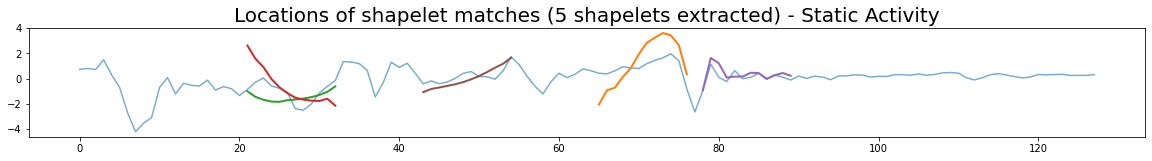

In [56]:
ts_id = 0 # 0 Static Activity
plt.figure(figsize=(20,2))
n_shapelets = sum(shapelet_sizes.values())
plt.title("Locations of shapelet matches "
          "({} shapelets extracted) - Static Activity".format(n_shapelets), fontsize=20)                         

plt.plot(X_test[ts_id].ravel(), alpha=0.6)
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

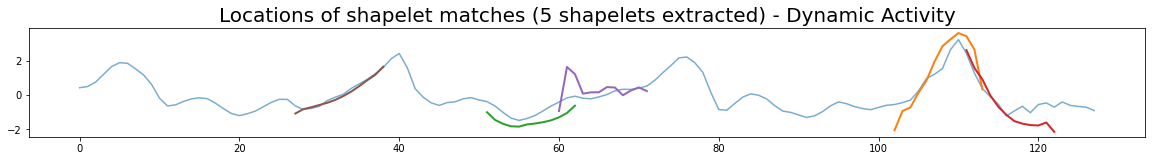

In [57]:
ts_id = 2942 # 1 Dynamic Activity
plt.figure(figsize=(20,2))
n_shapelets = sum(shapelet_sizes.values())
plt.title("Locations of shapelet matches "
          "({} shapelets extracted) - Dynamic Activity".format(n_shapelets), fontsize=20)                         

plt.plot(X_test[ts_id].ravel(), alpha=0.6)
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

In [58]:
# 1: Static ,   0: Dynamic
predicted_labels[:5]

array([0, 0, 0, 0, 1], dtype=int64)

In [59]:
y_test[:5]

,Activity
0,0
1,0
2,0
3,0
4,0


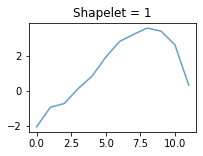

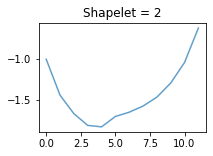

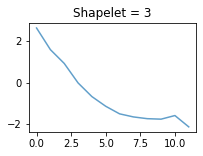

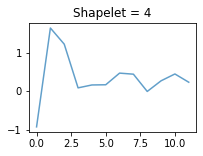

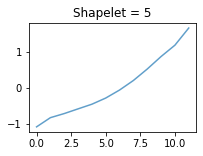

In [60]:
num_shap =[x for x in range(1,6)]
for  shapelet, i in zip(shp_clf.shapelets_, num_shap):
    
    plt.figure(figsize=(3,2))
    plt.title(f"Shapelet = {i}")
    plt.plot(shapelet, alpha=0.7)
    plt.show()

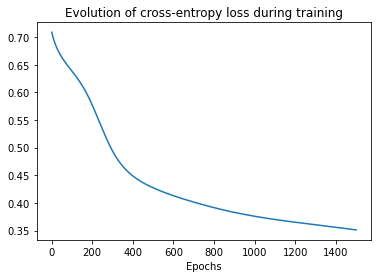

In [61]:
# The loss history is accessible via the `model_` that is a keras model
plt.figure()
plt.plot(np.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"])
plt.title("Evolution of cross-entropy loss during training")
plt.xlabel("Epochs")
plt.show()

### Test l = 0.01

In [19]:
n_ts, ts_sz = X_train.shape
n_classes = len(set(y_train.Activity))

# Set the number of shapelets per size as done in the original paper
# Compute number and length of shapelets.
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts, # numero di TS nel dataset
                                                       ts_sz=ts_sz, #lunghezza delle TS nel dataset
                                                       n_classes=n_classes, # numero di classi
                                                       l=0.01, # frazione della lunghezza delle TS da utilizzare come base per il shapelet length
                                                       r=1) # numero di differenti shapelet length da utilizzare

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 7352
ts_sz 128
n_classes 2
shapelet_sizes {1: 5}


In [20]:
# Define the model using parameters provided by the authors 
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        #optimizer=tf.optimizers.Adam(.01), # si usa il default sgd
                        weight_regularizer=.01,
                        max_iter=1500,
                        verbose=1)

In [21]:
shp_clf.fit(X_train, y_train)

Epoch 1/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.7087 - binary_accuracy: 0.5883 - binary_crossentropy: 0.6904
Epoch 2/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.7078 - binary_accuracy: 0.5585 - binary_crossentropy: 0.6897
Epoch 3/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.7070 - binary_accuracy: 0.5509 - binary_crossentropy: 0.6891
Epoch 4/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.7063 - binary_accuracy: 0.5501 - binary_crossentropy: 0.6886
Epoch 5/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.7056 - binary_accuracy: 0.5495 - binary_crossentropy: 0.6881
Epoch 6/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.7050 - binary_accuracy: 0.5507 - binary_crossentropy: 0.6877
Epoch 7/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.7045 - binary_accuracy: 0.5513 - binary_crossentropy: 0.6874
Epoch 8/1500
29/29 [=====================

29/29 [==============================] - 0s 2ms/step - loss: 0.6886 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6827
Epoch 120/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.6885 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6827
Epoch 121/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.6884 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6827
Epoch 122/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.6883 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6826
Epoch 123/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.6883 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6826
Epoch 124/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.6882 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6825
Epoch 125/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.6881 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6825
Epoch 126/1500
29/29 [====================

29/29 [==============================] - 0s 2ms/step - loss: 0.6821 - binary_accuracy: 0.5524 - binary_crossentropy: 0.6775
Epoch 179/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.6819 - binary_accuracy: 0.5524 - binary_crossentropy: 0.6774
Epoch 180/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.6817 - binary_accuracy: 0.5522 - binary_crossentropy: 0.6772
Epoch 181/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.6815 - binary_accuracy: 0.5521 - binary_crossentropy: 0.6770
Epoch 182/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.6813 - binary_accuracy: 0.5521 - binary_crossentropy: 0.6768
Epoch 183/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.6811 - binary_accuracy: 0.5520 - binary_crossentropy: 0.6766
Epoch 184/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.6809 - binary_accuracy: 0.5518 - binary_crossentropy: 0.6763
Epoch 185/1500
29/29 [====================

29/29 [==============================] - 0s 2ms/step - loss: 0.5674 - binary_accuracy: 0.8268 - binary_crossentropy: 0.5570
Epoch 238/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.5632 - binary_accuracy: 0.8277 - binary_crossentropy: 0.5527
Epoch 239/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.5594 - binary_accuracy: 0.8289 - binary_crossentropy: 0.5485
Epoch 240/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.5557 - binary_accuracy: 0.8286 - binary_crossentropy: 0.5447
Epoch 241/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.5522 - binary_accuracy: 0.8296 - binary_crossentropy: 0.5410
Epoch 242/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.5490 - binary_accuracy: 0.8298 - binary_crossentropy: 0.5376
Epoch 243/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.5458 - binary_accuracy: 0.8294 - binary_crossentropy: 0.5343
Epoch 244/1500
29/29 [====================

29/29 [==============================] - 0s 2ms/step - loss: 0.4768 - binary_accuracy: 0.8241 - binary_crossentropy: 0.4622
Epoch 297/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4763 - binary_accuracy: 0.8225 - binary_crossentropy: 0.4617
Epoch 298/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4758 - binary_accuracy: 0.8234 - binary_crossentropy: 0.4612
Epoch 299/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4753 - binary_accuracy: 0.8225 - binary_crossentropy: 0.4608
Epoch 300/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4749 - binary_accuracy: 0.8226 - binary_crossentropy: 0.4603
Epoch 301/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4744 - binary_accuracy: 0.8237 - binary_crossentropy: 0.4598
Epoch 302/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4740 - binary_accuracy: 0.8230 - binary_crossentropy: 0.4594
Epoch 303/1500
29/29 [====================

29/29 [==============================] - 0s 2ms/step - loss: 0.4587 - binary_accuracy: 0.8220 - binary_crossentropy: 0.4454
Epoch 356/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4585 - binary_accuracy: 0.8213 - binary_crossentropy: 0.4452
Epoch 357/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4583 - binary_accuracy: 0.8217 - binary_crossentropy: 0.4450
Epoch 358/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4581 - binary_accuracy: 0.8217 - binary_crossentropy: 0.4449
Epoch 359/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4579 - binary_accuracy: 0.8224 - binary_crossentropy: 0.4447
Epoch 360/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4577 - binary_accuracy: 0.8224 - binary_crossentropy: 0.4446
Epoch 361/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4575 - binary_accuracy: 0.8217 - binary_crossentropy: 0.4444
Epoch 362/1500
29/29 [====================

29/29 [==============================] - 0s 2ms/step - loss: 0.4504 - binary_accuracy: 0.8217 - binary_crossentropy: 0.4385
Epoch 415/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4503 - binary_accuracy: 0.8213 - binary_crossentropy: 0.4384
Epoch 416/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4502 - binary_accuracy: 0.8217 - binary_crossentropy: 0.4384
Epoch 417/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4501 - binary_accuracy: 0.8217 - binary_crossentropy: 0.4383
Epoch 418/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4500 - binary_accuracy: 0.8218 - binary_crossentropy: 0.4382
Epoch 419/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4499 - binary_accuracy: 0.8228 - binary_crossentropy: 0.4381
Epoch 420/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4498 - binary_accuracy: 0.8220 - binary_crossentropy: 0.4381
Epoch 421/1500
29/29 [====================

29/29 [==============================] - 0s 2ms/step - loss: 0.4455 - binary_accuracy: 0.8225 - binary_crossentropy: 0.4348
Epoch 474/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4454 - binary_accuracy: 0.8225 - binary_crossentropy: 0.4347
Epoch 475/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4454 - binary_accuracy: 0.8226 - binary_crossentropy: 0.4347
Epoch 476/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4453 - binary_accuracy: 0.8228 - binary_crossentropy: 0.4346
Epoch 477/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4452 - binary_accuracy: 0.8222 - binary_crossentropy: 0.4346
Epoch 478/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4452 - binary_accuracy: 0.8226 - binary_crossentropy: 0.4345
Epoch 479/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4451 - binary_accuracy: 0.8221 - binary_crossentropy: 0.4344
Epoch 480/1500
29/29 [====================

29/29 [==============================] - 0s 2ms/step - loss: 0.4422 - binary_accuracy: 0.8226 - binary_crossentropy: 0.4323
Epoch 533/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4422 - binary_accuracy: 0.8232 - binary_crossentropy: 0.4323
Epoch 534/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4421 - binary_accuracy: 0.8222 - binary_crossentropy: 0.4322
Epoch 535/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4421 - binary_accuracy: 0.8226 - binary_crossentropy: 0.4322
Epoch 536/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4420 - binary_accuracy: 0.8220 - binary_crossentropy: 0.4322
Epoch 537/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4420 - binary_accuracy: 0.8225 - binary_crossentropy: 0.4321
Epoch 538/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4419 - binary_accuracy: 0.8225 - binary_crossentropy: 0.4321
Epoch 539/1500
29/29 [====================

29/29 [==============================] - 0s 2ms/step - loss: 0.4398 - binary_accuracy: 0.8213 - binary_crossentropy: 0.4306
Epoch 592/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4399 - binary_accuracy: 0.8230 - binary_crossentropy: 0.4306
Epoch 593/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4398 - binary_accuracy: 0.8236 - binary_crossentropy: 0.4305
Epoch 594/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4398 - binary_accuracy: 0.8228 - binary_crossentropy: 0.4305
Epoch 595/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4397 - binary_accuracy: 0.8225 - binary_crossentropy: 0.4305
Epoch 596/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4397 - binary_accuracy: 0.8218 - binary_crossentropy: 0.4305
Epoch 597/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4397 - binary_accuracy: 0.8218 - binary_crossentropy: 0.4304
Epoch 598/1500
29/29 [====================

29/29 [==============================] - 0s 2ms/step - loss: 0.4381 - binary_accuracy: 0.8225 - binary_crossentropy: 0.4293
Epoch 651/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4380 - binary_accuracy: 0.8226 - binary_crossentropy: 0.4293
Epoch 652/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4381 - binary_accuracy: 0.8229 - binary_crossentropy: 0.4292
Epoch 653/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4380 - binary_accuracy: 0.8234 - binary_crossentropy: 0.4292
Epoch 654/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4380 - binary_accuracy: 0.8222 - binary_crossentropy: 0.4292
Epoch 655/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4380 - binary_accuracy: 0.8233 - binary_crossentropy: 0.4292
Epoch 656/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4379 - binary_accuracy: 0.8224 - binary_crossentropy: 0.4292
Epoch 657/1500
29/29 [====================

29/29 [==============================] - 0s 2ms/step - loss: 0.4367 - binary_accuracy: 0.8209 - binary_crossentropy: 0.4282
Epoch 710/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4366 - binary_accuracy: 0.8232 - binary_crossentropy: 0.4282
Epoch 711/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4366 - binary_accuracy: 0.8229 - binary_crossentropy: 0.4282
Epoch 712/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4366 - binary_accuracy: 0.8221 - binary_crossentropy: 0.4282
Epoch 713/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4366 - binary_accuracy: 0.8224 - binary_crossentropy: 0.4282
Epoch 714/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4366 - binary_accuracy: 0.8232 - binary_crossentropy: 0.4282
Epoch 715/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4366 - binary_accuracy: 0.8229 - binary_crossentropy: 0.4281
Epoch 716/1500
29/29 [====================

29/29 [==============================] - 0s 2ms/step - loss: 0.4355 - binary_accuracy: 0.8229 - binary_crossentropy: 0.4274
Epoch 769/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4356 - binary_accuracy: 0.8228 - binary_crossentropy: 0.4274
Epoch 770/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4355 - binary_accuracy: 0.8225 - binary_crossentropy: 0.4274
Epoch 771/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4356 - binary_accuracy: 0.8222 - binary_crossentropy: 0.4275
Epoch 772/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4355 - binary_accuracy: 0.8224 - binary_crossentropy: 0.4273
Epoch 773/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4355 - binary_accuracy: 0.8221 - binary_crossentropy: 0.4274
Epoch 774/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4354 - binary_accuracy: 0.8233 - binary_crossentropy: 0.4273
Epoch 775/1500
29/29 [====================

29/29 [==============================] - 0s 2ms/step - loss: 0.4347 - binary_accuracy: 0.8232 - binary_crossentropy: 0.4268
Epoch 828/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4346 - binary_accuracy: 0.8229 - binary_crossentropy: 0.4266
Epoch 829/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4346 - binary_accuracy: 0.8214 - binary_crossentropy: 0.4268
Epoch 830/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4346 - binary_accuracy: 0.8241 - binary_crossentropy: 0.4268
Epoch 831/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4346 - binary_accuracy: 0.8220 - binary_crossentropy: 0.4267
Epoch 832/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4345 - binary_accuracy: 0.8232 - binary_crossentropy: 0.4267
Epoch 833/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4346 - binary_accuracy: 0.8226 - binary_crossentropy: 0.4267
Epoch 834/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.4338 - binary_accuracy: 0.8230 - binary_crossentropy: 0.4261
Epoch 887/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4338 - binary_accuracy: 0.8229 - binary_crossentropy: 0.4261
Epoch 888/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4338 - binary_accuracy: 0.8226 - binary_crossentropy: 0.4261
Epoch 889/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4337 - binary_accuracy: 0.8237 - binary_crossentropy: 0.4261
Epoch 890/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4338 - binary_accuracy: 0.8224 - binary_crossentropy: 0.4261
Epoch 891/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4337 - binary_accuracy: 0.8230 - binary_crossentropy: 0.4260
Epoch 892/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4337 - binary_accuracy: 0.8211 - binary_crossentropy: 0.4261
Epoch 893/1500
29/29 [====================

29/29 [==============================] - 0s 2ms/step - loss: 0.4330 - binary_accuracy: 0.8229 - binary_crossentropy: 0.4255
Epoch 946/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4330 - binary_accuracy: 0.8225 - binary_crossentropy: 0.4256
Epoch 947/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4330 - binary_accuracy: 0.8225 - binary_crossentropy: 0.4256
Epoch 948/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4330 - binary_accuracy: 0.8234 - binary_crossentropy: 0.4255
Epoch 949/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4330 - binary_accuracy: 0.8240 - binary_crossentropy: 0.4256
Epoch 950/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4330 - binary_accuracy: 0.8229 - binary_crossentropy: 0.4256
Epoch 951/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4331 - binary_accuracy: 0.8228 - binary_crossentropy: 0.4256
Epoch 952/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.4324 - binary_accuracy: 0.8233 - binary_crossentropy: 0.4251
Epoch 1005/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4324 - binary_accuracy: 0.8232 - binary_crossentropy: 0.4252
Epoch 1006/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4324 - binary_accuracy: 0.8228 - binary_crossentropy: 0.4252
Epoch 1007/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4324 - binary_accuracy: 0.8229 - binary_crossentropy: 0.4251
Epoch 1008/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4324 - binary_accuracy: 0.8225 - binary_crossentropy: 0.4251
Epoch 1009/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4324 - binary_accuracy: 0.8234 - binary_crossentropy: 0.4251
Epoch 1010/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4323 - binary_accuracy: 0.8217 - binary_crossentropy: 0.4250
Epoch 1011/1500
29/29 [=============

29/29 [==============================] - 0s 3ms/step - loss: 0.4312 - binary_accuracy: 0.8213 - binary_crossentropy: 0.4243
Epoch 1121/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4314 - binary_accuracy: 0.8247 - binary_crossentropy: 0.4243
Epoch 1122/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4313 - binary_accuracy: 0.8229 - binary_crossentropy: 0.4243
Epoch 1123/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4313 - binary_accuracy: 0.8225 - binary_crossentropy: 0.4243
Epoch 1124/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4314 - binary_accuracy: 0.8249 - binary_crossentropy: 0.4244
Epoch 1125/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4314 - binary_accuracy: 0.8230 - binary_crossentropy: 0.4245
Epoch 1126/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4313 - binary_accuracy: 0.8226 - binary_crossentropy: 0.4243
Epoch 1127/1500
29/29 [=============

29/29 [==============================] - 0s 3ms/step - loss: 0.4305 - binary_accuracy: 0.8217 - binary_crossentropy: 0.4237
Epoch 1237/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4305 - binary_accuracy: 0.8230 - binary_crossentropy: 0.4237
Epoch 1238/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4305 - binary_accuracy: 0.8232 - binary_crossentropy: 0.4237
Epoch 1239/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4305 - binary_accuracy: 0.8234 - binary_crossentropy: 0.4238
Epoch 1240/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4305 - binary_accuracy: 0.8217 - binary_crossentropy: 0.4237
Epoch 1241/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4305 - binary_accuracy: 0.8234 - binary_crossentropy: 0.4237
Epoch 1242/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4305 - binary_accuracy: 0.8233 - binary_crossentropy: 0.4238
Epoch 1243/1500
29/29 [=============

29/29 [==============================] - 0s 2ms/step - loss: 0.4298 - binary_accuracy: 0.8228 - binary_crossentropy: 0.4233
Epoch 1353/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4299 - binary_accuracy: 0.8232 - binary_crossentropy: 0.4234
Epoch 1354/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4299 - binary_accuracy: 0.8237 - binary_crossentropy: 0.4233
Epoch 1355/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4299 - binary_accuracy: 0.8232 - binary_crossentropy: 0.4233
Epoch 1356/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4298 - binary_accuracy: 0.8229 - binary_crossentropy: 0.4233
Epoch 1357/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4300 - binary_accuracy: 0.8236 - binary_crossentropy: 0.4234
Epoch 1358/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4299 - binary_accuracy: 0.8215 - binary_crossentropy: 0.4234
Epoch 1359/1500
29/29 [=============

29/29 [==============================] - 0s 2ms/step - loss: 0.4293 - binary_accuracy: 0.8226 - binary_crossentropy: 0.4230
Epoch 1469/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4292 - binary_accuracy: 0.8229 - binary_crossentropy: 0.4228
Epoch 1470/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4292 - binary_accuracy: 0.8229 - binary_crossentropy: 0.4228
Epoch 1471/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4293 - binary_accuracy: 0.8245 - binary_crossentropy: 0.4230
Epoch 1472/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4292 - binary_accuracy: 0.8233 - binary_crossentropy: 0.4229
Epoch 1473/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4292 - binary_accuracy: 0.8221 - binary_crossentropy: 0.4229
Epoch 1474/1500
29/29 [==============================] - 0s 2ms/step - loss: 0.4293 - binary_accuracy: 0.8233 - binary_crossentropy: 0.4229
Epoch 1475/1500
29/29 [=============

LearningShapelets(max_iter=1500, n_shapelets_per_size={1: 5}, verbose=1,
                  weight_regularizer=0.01)

In [22]:
predicted_labels = shp_clf.predict(X_test)

12/12 [==============================] - 0s 1ms/step


In [23]:
predicted_locations = shp_clf.locate(X_test)

12/12 [==============================] - 0s 2ms/step


In [24]:
from sklearn.metrics import classification_report, accuracy_score

In [25]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1560
           1       0.84      0.84      0.84      1387

    accuracy                           0.85      2947
   macro avg       0.85      0.85      0.85      2947
weighted avg       0.85      0.85      0.85      2947



### Test l = 0.05

In [27]:
n_ts, ts_sz = X_train.shape
n_classes = len(set(y_train.Activity))

# Set the number of shapelets per size as done in the original paper
# Compute number and length of shapelets.
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts, # numero di TS nel dataset
                                                       ts_sz=ts_sz, #lunghezza delle TS nel dataset
                                                       n_classes=n_classes, # numero di classi
                                                       l=0.05, # frazione della lunghezza delle TS da utilizzare come base per il shapelet length
                                                       r=1) # numero di differenti shapelet length da utilizzare

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 7352
ts_sz 128
n_classes 2
shapelet_sizes {6: 5}


In [28]:
# Define the model using parameters provided by the authors 
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        #optimizer=tf.optimizers.Adam(.01), # si usa il default sgd
                        weight_regularizer=.01,
                        max_iter=1500,
                        verbose=1)

In [29]:
shp_clf.fit(X_train, y_train)

Epoch 1/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.7233 - binary_accuracy: 0.4501 - binary_crossentropy: 0.7110
Epoch 2/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.7204 - binary_accuracy: 0.4418 - binary_crossentropy: 0.7083
Epoch 3/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.7178 - binary_accuracy: 0.4260 - binary_crossentropy: 0.7059
Epoch 4/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.7155 - binary_accuracy: 0.4183 - binary_crossentropy: 0.7039
Epoch 5/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.7135 - binary_accuracy: 0.4210 - binary_crossentropy: 0.7021
Epoch 6/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.7116 - binary_accuracy: 0.4346 - binary_crossentropy: 0.7005
Epoch 7/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.7100 - binary_accuracy: 0.4478 - binary_crossentropy: 0.6991
Epoch 8/1500
29/29 [=====================

29/29 [==============================] - 0s 3ms/step - loss: 0.6796 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6739
Epoch 120/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6795 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6738
Epoch 121/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6794 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6737
Epoch 122/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6793 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6736
Epoch 123/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6792 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6735
Epoch 124/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6791 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6734
Epoch 125/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6791 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6733
Epoch 126/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.6748 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6679
Epoch 179/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6747 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6678
Epoch 180/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6746 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6677
Epoch 181/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6746 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6676
Epoch 182/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6745 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6674
Epoch 183/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6744 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6673
Epoch 184/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6743 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6672
Epoch 185/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.6702 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6612
Epoch 238/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6701 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6611
Epoch 239/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6701 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6610
Epoch 240/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6700 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6609
Epoch 241/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6699 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6608
Epoch 242/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6698 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6606
Epoch 243/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6698 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6605
Epoch 244/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.6660 - binary_accuracy: 0.5533 - binary_crossentropy: 0.6545
Epoch 297/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6659 - binary_accuracy: 0.5533 - binary_crossentropy: 0.6544
Epoch 298/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6659 - binary_accuracy: 0.5533 - binary_crossentropy: 0.6543
Epoch 299/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6658 - binary_accuracy: 0.5533 - binary_crossentropy: 0.6542
Epoch 300/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6657 - binary_accuracy: 0.5533 - binary_crossentropy: 0.6541
Epoch 301/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6657 - binary_accuracy: 0.5533 - binary_crossentropy: 0.6540
Epoch 302/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6656 - binary_accuracy: 0.5533 - binary_crossentropy: 0.6539
Epoch 303/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.6627 - binary_accuracy: 0.5547 - binary_crossentropy: 0.6486
Epoch 356/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6626 - binary_accuracy: 0.5547 - binary_crossentropy: 0.6485
Epoch 357/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6626 - binary_accuracy: 0.5547 - binary_crossentropy: 0.6484
Epoch 358/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6625 - binary_accuracy: 0.5547 - binary_crossentropy: 0.6483
Epoch 359/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6625 - binary_accuracy: 0.5547 - binary_crossentropy: 0.6483
Epoch 360/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6624 - binary_accuracy: 0.5551 - binary_crossentropy: 0.6482
Epoch 361/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6624 - binary_accuracy: 0.5554 - binary_crossentropy: 0.6481
Epoch 362/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.6600 - binary_accuracy: 0.5613 - binary_crossentropy: 0.6436
Epoch 415/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6599 - binary_accuracy: 0.5618 - binary_crossentropy: 0.6435
Epoch 416/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6599 - binary_accuracy: 0.5620 - binary_crossentropy: 0.6435
Epoch 417/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6599 - binary_accuracy: 0.5627 - binary_crossentropy: 0.6434
Epoch 418/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6598 - binary_accuracy: 0.5626 - binary_crossentropy: 0.6433
Epoch 419/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6598 - binary_accuracy: 0.5627 - binary_crossentropy: 0.6432
Epoch 420/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6597 - binary_accuracy: 0.5627 - binary_crossentropy: 0.6431
Epoch 421/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.6573 - binary_accuracy: 0.5873 - binary_crossentropy: 0.6388
Epoch 474/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6573 - binary_accuracy: 0.5877 - binary_crossentropy: 0.6387
Epoch 475/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6572 - binary_accuracy: 0.5880 - binary_crossentropy: 0.6387
Epoch 476/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6572 - binary_accuracy: 0.5892 - binary_crossentropy: 0.6386
Epoch 477/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6571 - binary_accuracy: 0.5892 - binary_crossentropy: 0.6385
Epoch 478/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6570 - binary_accuracy: 0.5905 - binary_crossentropy: 0.6384
Epoch 479/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6570 - binary_accuracy: 0.5905 - binary_crossentropy: 0.6383
Epoch 480/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.6536 - binary_accuracy: 0.6303 - binary_crossentropy: 0.6330
Epoch 533/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6536 - binary_accuracy: 0.6298 - binary_crossentropy: 0.6329
Epoch 534/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6535 - binary_accuracy: 0.6308 - binary_crossentropy: 0.6328
Epoch 535/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6534 - binary_accuracy: 0.6319 - binary_crossentropy: 0.6327
Epoch 536/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6533 - binary_accuracy: 0.6323 - binary_crossentropy: 0.6325
Epoch 537/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6532 - binary_accuracy: 0.6328 - binary_crossentropy: 0.6324
Epoch 538/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6532 - binary_accuracy: 0.6340 - binary_crossentropy: 0.6323
Epoch 539/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.6478 - binary_accuracy: 0.6863 - binary_crossentropy: 0.6246
Epoch 592/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6477 - binary_accuracy: 0.6881 - binary_crossentropy: 0.6245
Epoch 593/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6476 - binary_accuracy: 0.6881 - binary_crossentropy: 0.6243
Epoch 594/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6475 - binary_accuracy: 0.6887 - binary_crossentropy: 0.6241
Epoch 595/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6473 - binary_accuracy: 0.6897 - binary_crossentropy: 0.6239
Epoch 596/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6472 - binary_accuracy: 0.6899 - binary_crossentropy: 0.6238
Epoch 597/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6471 - binary_accuracy: 0.6933 - binary_crossentropy: 0.6236
Epoch 598/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.6383 - binary_accuracy: 0.7476 - binary_crossentropy: 0.6116
Epoch 651/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6381 - binary_accuracy: 0.7490 - binary_crossentropy: 0.6113
Epoch 652/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6379 - binary_accuracy: 0.7503 - binary_crossentropy: 0.6111
Epoch 653/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6377 - binary_accuracy: 0.7511 - binary_crossentropy: 0.6108
Epoch 654/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6375 - binary_accuracy: 0.7522 - binary_crossentropy: 0.6105
Epoch 655/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6373 - binary_accuracy: 0.7510 - binary_crossentropy: 0.6102
Epoch 656/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6371 - binary_accuracy: 0.7537 - binary_crossentropy: 0.6099
Epoch 657/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.6239 - binary_accuracy: 0.7968 - binary_crossentropy: 0.5924
Epoch 710/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6236 - binary_accuracy: 0.7976 - binary_crossentropy: 0.5920
Epoch 711/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6233 - binary_accuracy: 0.7975 - binary_crossentropy: 0.5916
Epoch 712/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6230 - binary_accuracy: 0.7987 - binary_crossentropy: 0.5912
Epoch 713/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6227 - binary_accuracy: 0.7998 - binary_crossentropy: 0.5908
Epoch 714/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6224 - binary_accuracy: 0.8009 - binary_crossentropy: 0.5904
Epoch 715/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6221 - binary_accuracy: 0.8017 - binary_crossentropy: 0.5900
Epoch 716/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.6034 - binary_accuracy: 0.8241 - binary_crossentropy: 0.5659
Epoch 769/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6030 - binary_accuracy: 0.8260 - binary_crossentropy: 0.5654
Epoch 770/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6025 - binary_accuracy: 0.8263 - binary_crossentropy: 0.5649
Epoch 771/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6021 - binary_accuracy: 0.8263 - binary_crossentropy: 0.5644
Epoch 772/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6017 - binary_accuracy: 0.8259 - binary_crossentropy: 0.5638
Epoch 773/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6013 - binary_accuracy: 0.8264 - binary_crossentropy: 0.5633
Epoch 774/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6009 - binary_accuracy: 0.8263 - binary_crossentropy: 0.5628
Epoch 775/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.5745 - binary_accuracy: 0.8354 - binary_crossentropy: 0.5302
Epoch 828/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5740 - binary_accuracy: 0.8356 - binary_crossentropy: 0.5295
Epoch 829/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5734 - binary_accuracy: 0.8354 - binary_crossentropy: 0.5288
Epoch 830/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5729 - binary_accuracy: 0.8354 - binary_crossentropy: 0.5281
Epoch 831/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5723 - binary_accuracy: 0.8350 - binary_crossentropy: 0.5274
Epoch 832/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5718 - binary_accuracy: 0.8350 - binary_crossentropy: 0.5267
Epoch 833/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5712 - binary_accuracy: 0.8354 - binary_crossentropy: 0.5260
Epoch 834/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.5427 - binary_accuracy: 0.8339 - binary_crossentropy: 0.4909
Epoch 887/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5422 - binary_accuracy: 0.8342 - binary_crossentropy: 0.4904
Epoch 888/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5418 - binary_accuracy: 0.8339 - binary_crossentropy: 0.4898
Epoch 889/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5413 - binary_accuracy: 0.8339 - binary_crossentropy: 0.4892
Epoch 890/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5408 - binary_accuracy: 0.8338 - binary_crossentropy: 0.4886
Epoch 891/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5404 - binary_accuracy: 0.8339 - binary_crossentropy: 0.4880
Epoch 892/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5399 - binary_accuracy: 0.8337 - binary_crossentropy: 0.4875
Epoch 893/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.5215 - binary_accuracy: 0.8259 - binary_crossentropy: 0.4648
Epoch 946/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5213 - binary_accuracy: 0.8256 - binary_crossentropy: 0.4645
Epoch 947/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5211 - binary_accuracy: 0.8264 - binary_crossentropy: 0.4642
Epoch 948/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5208 - binary_accuracy: 0.8259 - binary_crossentropy: 0.4639
Epoch 949/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5205 - binary_accuracy: 0.8256 - binary_crossentropy: 0.4636
Epoch 950/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5203 - binary_accuracy: 0.8255 - binary_crossentropy: 0.4633
Epoch 951/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5201 - binary_accuracy: 0.8252 - binary_crossentropy: 0.4630
Epoch 952/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.5103 - binary_accuracy: 0.8222 - binary_crossentropy: 0.4522
Epoch 1005/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5101 - binary_accuracy: 0.8226 - binary_crossentropy: 0.4520
Epoch 1006/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5100 - binary_accuracy: 0.8218 - binary_crossentropy: 0.4519
Epoch 1007/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5098 - binary_accuracy: 0.8211 - binary_crossentropy: 0.4517
Epoch 1008/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5097 - binary_accuracy: 0.8221 - binary_crossentropy: 0.4516
Epoch 1009/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5095 - binary_accuracy: 0.8215 - binary_crossentropy: 0.4515
Epoch 1010/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5094 - binary_accuracy: 0.8215 - binary_crossentropy: 0.4513
Epoch 1011/1500
29/29 [=============

29/29 [==============================] - 0s 3ms/step - loss: 0.4977 - binary_accuracy: 0.8183 - binary_crossentropy: 0.4414
Epoch 1121/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4976 - binary_accuracy: 0.8181 - binary_crossentropy: 0.4413
Epoch 1122/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4975 - binary_accuracy: 0.8183 - binary_crossentropy: 0.4412
Epoch 1123/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4974 - binary_accuracy: 0.8183 - binary_crossentropy: 0.4412
Epoch 1124/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4974 - binary_accuracy: 0.8176 - binary_crossentropy: 0.4411
Epoch 1125/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4973 - binary_accuracy: 0.8183 - binary_crossentropy: 0.4410
Epoch 1126/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4972 - binary_accuracy: 0.8187 - binary_crossentropy: 0.4410
Epoch 1127/1500
29/29 [=============

29/29 [==============================] - 0s 3ms/step - loss: 0.4892 - binary_accuracy: 0.8225 - binary_crossentropy: 0.4346
Epoch 1237/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4891 - binary_accuracy: 0.8217 - binary_crossentropy: 0.4346
Epoch 1238/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4891 - binary_accuracy: 0.8226 - binary_crossentropy: 0.4345
Epoch 1239/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4890 - binary_accuracy: 0.8228 - binary_crossentropy: 0.4345
Epoch 1240/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4889 - binary_accuracy: 0.8222 - binary_crossentropy: 0.4344
Epoch 1241/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4889 - binary_accuracy: 0.8225 - binary_crossentropy: 0.4344
Epoch 1242/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4888 - binary_accuracy: 0.8224 - binary_crossentropy: 0.4343
Epoch 1243/1500
29/29 [=============

29/29 [==============================] - 0s 3ms/step - loss: 0.4824 - binary_accuracy: 0.8240 - binary_crossentropy: 0.4287
Epoch 1353/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4824 - binary_accuracy: 0.8244 - binary_crossentropy: 0.4286
Epoch 1354/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4823 - binary_accuracy: 0.8239 - binary_crossentropy: 0.4286
Epoch 1355/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4823 - binary_accuracy: 0.8247 - binary_crossentropy: 0.4285
Epoch 1356/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4822 - binary_accuracy: 0.8236 - binary_crossentropy: 0.4285
Epoch 1357/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4822 - binary_accuracy: 0.8247 - binary_crossentropy: 0.4284
Epoch 1358/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4821 - binary_accuracy: 0.8241 - binary_crossentropy: 0.4284
Epoch 1359/1500
29/29 [=============

29/29 [==============================] - 0s 4ms/step - loss: 0.4768 - binary_accuracy: 0.8292 - binary_crossentropy: 0.4233
Epoch 1469/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4767 - binary_accuracy: 0.8296 - binary_crossentropy: 0.4233
Epoch 1470/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4767 - binary_accuracy: 0.8303 - binary_crossentropy: 0.4233
Epoch 1471/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4766 - binary_accuracy: 0.8292 - binary_crossentropy: 0.4232
Epoch 1472/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4766 - binary_accuracy: 0.8288 - binary_crossentropy: 0.4232
Epoch 1473/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4765 - binary_accuracy: 0.8293 - binary_crossentropy: 0.4231
Epoch 1474/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4765 - binary_accuracy: 0.8301 - binary_crossentropy: 0.4231
Epoch 1475/1500
29/29 [=============

LearningShapelets(max_iter=1500, n_shapelets_per_size={6: 5}, verbose=1,
                  weight_regularizer=0.01)

In [30]:
predicted_labels = shp_clf.predict(X_test)

12/12 [==============================] - 0s 3ms/step


In [31]:
predicted_locations = shp_clf.locate(X_test)

12/12 [==============================] - 0s 2ms/step


In [32]:
from sklearn.metrics import classification_report, accuracy_score

In [33]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1560
           1       0.80      0.85      0.82      1387

    accuracy                           0.83      2947
   macro avg       0.83      0.83      0.83      2947
weighted avg       0.83      0.83      0.83      2947



### Test l = 0.08

In [70]:
n_ts, ts_sz = X_train.shape
n_classes = len(set(y_train.Activity))

# Set the number of shapelets per size as done in the original paper
# Compute number and length of shapelets.
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts, # numero di TS nel dataset
                                                       ts_sz=ts_sz, #lunghezza delle TS nel dataset
                                                       n_classes=n_classes, # numero di classi
                                                       l=0.08, # frazione della lunghezza delle TS da utilizzare come base per il shapelet length
                                                       r=1) # numero di differenti shapelet length da utilizzare

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 7352
ts_sz 128
n_classes 2
shapelet_sizes {10: 5}


In [71]:
# Define the model using parameters provided by the authors 
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        #optimizer=tf.optimizers.Adam(.01), # si usa il default sgd
                        weight_regularizer=.01,
                        max_iter=1500,
                        verbose=1)

In [72]:
shp_clf.fit(X_train, y_train)

Epoch 1/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6686 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6538
Epoch 2/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6683 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6534
Epoch 3/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6680 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6531
Epoch 4/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6676 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6528
Epoch 5/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6673 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6525
Epoch 6/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6670 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6522
Epoch 7/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6667 - binary_accuracy: 0.5532 - binary_crossentropy: 0.6519
Epoch 8/1500
29/29 [=====================

29/29 [==============================] - 0s 4ms/step - loss: 0.6354 - binary_accuracy: 0.6908 - binary_crossentropy: 0.6131
Epoch 120/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6350 - binary_accuracy: 0.6925 - binary_crossentropy: 0.6126
Epoch 121/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6346 - binary_accuracy: 0.6937 - binary_crossentropy: 0.6121
Epoch 122/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.6343 - binary_accuracy: 0.6953 - binary_crossentropy: 0.6116
Epoch 123/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6339 - binary_accuracy: 0.6989 - binary_crossentropy: 0.6112
Epoch 124/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6335 - binary_accuracy: 0.7005 - binary_crossentropy: 0.6107
Epoch 125/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6331 - binary_accuracy: 0.7058 - binary_crossentropy: 0.6102
Epoch 126/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.6095 - binary_accuracy: 0.8175 - binary_crossentropy: 0.5793
Epoch 179/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6090 - binary_accuracy: 0.8203 - binary_crossentropy: 0.5786
Epoch 180/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6085 - binary_accuracy: 0.8205 - binary_crossentropy: 0.5779
Epoch 181/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6080 - binary_accuracy: 0.8244 - binary_crossentropy: 0.5773
Epoch 182/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6074 - binary_accuracy: 0.8260 - binary_crossentropy: 0.5766
Epoch 183/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6069 - binary_accuracy: 0.8264 - binary_crossentropy: 0.5759
Epoch 184/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.6064 - binary_accuracy: 0.8282 - binary_crossentropy: 0.5752
Epoch 185/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.5752 - binary_accuracy: 0.8849 - binary_crossentropy: 0.5349
Epoch 238/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5746 - binary_accuracy: 0.8844 - binary_crossentropy: 0.5341
Epoch 239/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5739 - binary_accuracy: 0.8856 - binary_crossentropy: 0.5332
Epoch 240/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5733 - binary_accuracy: 0.8868 - binary_crossentropy: 0.5324
Epoch 241/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5726 - binary_accuracy: 0.8881 - binary_crossentropy: 0.5316
Epoch 242/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5720 - binary_accuracy: 0.8885 - binary_crossentropy: 0.5308
Epoch 243/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5714 - binary_accuracy: 0.8889 - binary_crossentropy: 0.5299
Epoch 244/1500
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: 0.5356 - binary_accuracy: 0.9055 - binary_crossentropy: 0.4846
Epoch 297/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5350 - binary_accuracy: 0.9057 - binary_crossentropy: 0.4838
Epoch 298/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5343 - binary_accuracy: 0.9057 - binary_crossentropy: 0.4830
Epoch 299/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.5336 - binary_accuracy: 0.9060 - binary_crossentropy: 0.4821
Epoch 300/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5329 - binary_accuracy: 0.9063 - binary_crossentropy: 0.4813
Epoch 301/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5323 - binary_accuracy: 0.9067 - binary_crossentropy: 0.4804
Epoch 302/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.5316 - binary_accuracy: 0.9072 - binary_crossentropy: 0.4796
Epoch 303/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4984 - binary_accuracy: 0.9146 - binary_crossentropy: 0.4384
Epoch 356/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4979 - binary_accuracy: 0.9147 - binary_crossentropy: 0.4377
Epoch 357/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4973 - binary_accuracy: 0.9149 - binary_crossentropy: 0.4370
Epoch 358/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4968 - binary_accuracy: 0.9147 - binary_crossentropy: 0.4363
Epoch 359/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4962 - binary_accuracy: 0.9146 - binary_crossentropy: 0.4356
Epoch 360/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4956 - binary_accuracy: 0.9142 - binary_crossentropy: 0.4349
Epoch 361/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4951 - binary_accuracy: 0.9142 - binary_crossentropy: 0.4343
Epoch 362/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4695 - binary_accuracy: 0.9178 - binary_crossentropy: 0.4029
Epoch 415/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4691 - binary_accuracy: 0.9180 - binary_crossentropy: 0.4024
Epoch 416/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4687 - binary_accuracy: 0.9178 - binary_crossentropy: 0.4020
Epoch 417/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4683 - binary_accuracy: 0.9178 - binary_crossentropy: 0.4015
Epoch 418/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4679 - binary_accuracy: 0.9178 - binary_crossentropy: 0.4010
Epoch 419/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4675 - binary_accuracy: 0.9177 - binary_crossentropy: 0.4005
Epoch 420/1500
29/29 [==============================] - 0s 3ms/step - loss: 0.4671 - binary_accuracy: 0.9178 - binary_crossentropy: 0.4000
Epoch 421/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4491 - binary_accuracy: 0.9174 - binary_crossentropy: 0.3783
Epoch 474/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4488 - binary_accuracy: 0.9177 - binary_crossentropy: 0.3780
Epoch 475/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4485 - binary_accuracy: 0.9177 - binary_crossentropy: 0.3776
Epoch 476/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4482 - binary_accuracy: 0.9176 - binary_crossentropy: 0.3773
Epoch 477/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4480 - binary_accuracy: 0.9174 - binary_crossentropy: 0.3770
Epoch 478/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4477 - binary_accuracy: 0.9174 - binary_crossentropy: 0.3766
Epoch 479/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4474 - binary_accuracy: 0.9170 - binary_crossentropy: 0.3763
Epoch 480/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4352 - binary_accuracy: 0.9178 - binary_crossentropy: 0.3620
Epoch 533/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4350 - binary_accuracy: 0.9178 - binary_crossentropy: 0.3618
Epoch 534/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4348 - binary_accuracy: 0.9174 - binary_crossentropy: 0.3616
Epoch 535/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4346 - binary_accuracy: 0.9176 - binary_crossentropy: 0.3614
Epoch 536/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4344 - binary_accuracy: 0.9176 - binary_crossentropy: 0.3612
Epoch 537/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4343 - binary_accuracy: 0.9176 - binary_crossentropy: 0.3609
Epoch 538/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4341 - binary_accuracy: 0.9177 - binary_crossentropy: 0.3607
Epoch 539/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4257 - binary_accuracy: 0.9154 - binary_crossentropy: 0.3514
Epoch 592/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4256 - binary_accuracy: 0.9154 - binary_crossentropy: 0.3513
Epoch 593/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4255 - binary_accuracy: 0.9154 - binary_crossentropy: 0.3511
Epoch 594/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4253 - binary_accuracy: 0.9155 - binary_crossentropy: 0.3510
Epoch 595/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4252 - binary_accuracy: 0.9153 - binary_crossentropy: 0.3508
Epoch 596/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4251 - binary_accuracy: 0.9149 - binary_crossentropy: 0.3507
Epoch 597/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4249 - binary_accuracy: 0.9151 - binary_crossentropy: 0.3505
Epoch 598/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4191 - binary_accuracy: 0.9128 - binary_crossentropy: 0.3444
Epoch 651/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4190 - binary_accuracy: 0.9131 - binary_crossentropy: 0.3442
Epoch 652/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4189 - binary_accuracy: 0.9129 - binary_crossentropy: 0.3442
Epoch 653/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4188 - binary_accuracy: 0.9129 - binary_crossentropy: 0.3441
Epoch 654/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4187 - binary_accuracy: 0.9128 - binary_crossentropy: 0.3440
Epoch 655/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4186 - binary_accuracy: 0.9128 - binary_crossentropy: 0.3439
Epoch 656/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4185 - binary_accuracy: 0.9132 - binary_crossentropy: 0.3438
Epoch 657/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4142 - binary_accuracy: 0.9113 - binary_crossentropy: 0.3395
Epoch 710/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4141 - binary_accuracy: 0.9116 - binary_crossentropy: 0.3395
Epoch 711/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4140 - binary_accuracy: 0.9113 - binary_crossentropy: 0.3393
Epoch 712/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4140 - binary_accuracy: 0.9110 - binary_crossentropy: 0.3393
Epoch 713/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4139 - binary_accuracy: 0.9113 - binary_crossentropy: 0.3392
Epoch 714/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4138 - binary_accuracy: 0.9116 - binary_crossentropy: 0.3392
Epoch 715/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4138 - binary_accuracy: 0.9117 - binary_crossentropy: 0.3391
Epoch 716/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4106 - binary_accuracy: 0.9112 - binary_crossentropy: 0.3360
Epoch 769/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4105 - binary_accuracy: 0.9109 - binary_crossentropy: 0.3360
Epoch 770/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4104 - binary_accuracy: 0.9109 - binary_crossentropy: 0.3359
Epoch 771/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4104 - binary_accuracy: 0.9105 - binary_crossentropy: 0.3359
Epoch 772/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4103 - binary_accuracy: 0.9106 - binary_crossentropy: 0.3358
Epoch 773/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4103 - binary_accuracy: 0.9106 - binary_crossentropy: 0.3358
Epoch 774/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4102 - binary_accuracy: 0.9104 - binary_crossentropy: 0.3357
Epoch 775/1500
29/29 [====================

29/29 [==============================] - 0s 5ms/step - loss: 0.4077 - binary_accuracy: 0.9101 - binary_crossentropy: 0.3334
Epoch 828/1500
29/29 [==============================] - 0s 5ms/step - loss: 0.4076 - binary_accuracy: 0.9101 - binary_crossentropy: 0.3333
Epoch 829/1500
29/29 [==============================] - 0s 5ms/step - loss: 0.4076 - binary_accuracy: 0.9102 - binary_crossentropy: 0.3333
Epoch 830/1500
29/29 [==============================] - 0s 5ms/step - loss: 0.4075 - binary_accuracy: 0.9101 - binary_crossentropy: 0.3333
Epoch 831/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4075 - binary_accuracy: 0.9101 - binary_crossentropy: 0.3332
Epoch 832/1500
29/29 [==============================] - 0s 5ms/step - loss: 0.4074 - binary_accuracy: 0.9100 - binary_crossentropy: 0.3332
Epoch 833/1500
29/29 [==============================] - 0s 5ms/step - loss: 0.4074 - binary_accuracy: 0.9101 - binary_crossentropy: 0.3332
Epoch 834/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4052 - binary_accuracy: 0.9089 - binary_crossentropy: 0.3313
Epoch 887/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4052 - binary_accuracy: 0.9089 - binary_crossentropy: 0.3312
Epoch 888/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4051 - binary_accuracy: 0.9089 - binary_crossentropy: 0.3312
Epoch 889/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4051 - binary_accuracy: 0.9089 - binary_crossentropy: 0.3312
Epoch 890/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4050 - binary_accuracy: 0.9089 - binary_crossentropy: 0.3311
Epoch 891/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4050 - binary_accuracy: 0.9089 - binary_crossentropy: 0.3311
Epoch 892/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4050 - binary_accuracy: 0.9089 - binary_crossentropy: 0.3311
Epoch 893/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4029 - binary_accuracy: 0.9079 - binary_crossentropy: 0.3294
Epoch 946/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4029 - binary_accuracy: 0.9081 - binary_crossentropy: 0.3293
Epoch 947/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4029 - binary_accuracy: 0.9081 - binary_crossentropy: 0.3293
Epoch 948/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4028 - binary_accuracy: 0.9082 - binary_crossentropy: 0.3292
Epoch 949/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4028 - binary_accuracy: 0.9082 - binary_crossentropy: 0.3292
Epoch 950/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4028 - binary_accuracy: 0.9082 - binary_crossentropy: 0.3292
Epoch 951/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4027 - binary_accuracy: 0.9079 - binary_crossentropy: 0.3291
Epoch 952/1500
29/29 [====================

29/29 [==============================] - 0s 4ms/step - loss: 0.4009 - binary_accuracy: 0.9074 - binary_crossentropy: 0.3276
Epoch 1005/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4009 - binary_accuracy: 0.9075 - binary_crossentropy: 0.3275
Epoch 1006/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4009 - binary_accuracy: 0.9075 - binary_crossentropy: 0.3275
Epoch 1007/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4008 - binary_accuracy: 0.9074 - binary_crossentropy: 0.3275
Epoch 1008/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4008 - binary_accuracy: 0.9076 - binary_crossentropy: 0.3275
Epoch 1009/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4008 - binary_accuracy: 0.9074 - binary_crossentropy: 0.3275
Epoch 1010/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.4007 - binary_accuracy: 0.9074 - binary_crossentropy: 0.3274
Epoch 1011/1500
29/29 [=============

29/29 [==============================] - 0s 4ms/step - loss: 0.3973 - binary_accuracy: 0.9066 - binary_crossentropy: 0.3245
Epoch 1121/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3973 - binary_accuracy: 0.9066 - binary_crossentropy: 0.3245
Epoch 1122/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3972 - binary_accuracy: 0.9066 - binary_crossentropy: 0.3245
Epoch 1123/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3972 - binary_accuracy: 0.9067 - binary_crossentropy: 0.3244
Epoch 1124/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3972 - binary_accuracy: 0.9066 - binary_crossentropy: 0.3244
Epoch 1125/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3971 - binary_accuracy: 0.9066 - binary_crossentropy: 0.3244
Epoch 1126/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3971 - binary_accuracy: 0.9068 - binary_crossentropy: 0.3244
Epoch 1127/1500
29/29 [=============

29/29 [==============================] - 0s 5ms/step - loss: 0.3938 - binary_accuracy: 0.9076 - binary_crossentropy: 0.3214
Epoch 1237/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3938 - binary_accuracy: 0.9078 - binary_crossentropy: 0.3214
Epoch 1238/1500
29/29 [==============================] - 0s 5ms/step - loss: 0.3938 - binary_accuracy: 0.9076 - binary_crossentropy: 0.3214
Epoch 1239/1500
29/29 [==============================] - 0s 5ms/step - loss: 0.3937 - binary_accuracy: 0.9078 - binary_crossentropy: 0.3214
Epoch 1240/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3937 - binary_accuracy: 0.9078 - binary_crossentropy: 0.3213
Epoch 1241/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3937 - binary_accuracy: 0.9078 - binary_crossentropy: 0.3213
Epoch 1242/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3936 - binary_accuracy: 0.9076 - binary_crossentropy: 0.3213
Epoch 1243/1500
29/29 [=============

29/29 [==============================] - 0s 4ms/step - loss: 0.3905 - binary_accuracy: 0.9081 - binary_crossentropy: 0.3183
Epoch 1353/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3904 - binary_accuracy: 0.9082 - binary_crossentropy: 0.3183
Epoch 1354/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3904 - binary_accuracy: 0.9086 - binary_crossentropy: 0.3183
Epoch 1355/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3904 - binary_accuracy: 0.9083 - binary_crossentropy: 0.3182
Epoch 1356/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3904 - binary_accuracy: 0.9082 - binary_crossentropy: 0.3182
Epoch 1357/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3903 - binary_accuracy: 0.9082 - binary_crossentropy: 0.3182
Epoch 1358/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3903 - binary_accuracy: 0.9081 - binary_crossentropy: 0.3181
Epoch 1359/1500
29/29 [=============

29/29 [==============================] - 0s 5ms/step - loss: 0.3873 - binary_accuracy: 0.9093 - binary_crossentropy: 0.3152
Epoch 1469/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3873 - binary_accuracy: 0.9089 - binary_crossentropy: 0.3152
Epoch 1470/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3872 - binary_accuracy: 0.9091 - binary_crossentropy: 0.3151
Epoch 1471/1500
29/29 [==============================] - 0s 4ms/step - loss: 0.3872 - binary_accuracy: 0.9093 - binary_crossentropy: 0.3152
Epoch 1472/1500
29/29 [==============================] - 0s 5ms/step - loss: 0.3872 - binary_accuracy: 0.9091 - binary_crossentropy: 0.3151
Epoch 1473/1500
29/29 [==============================] - 0s 5ms/step - loss: 0.3872 - binary_accuracy: 0.9095 - binary_crossentropy: 0.3151
Epoch 1474/1500
29/29 [==============================] - 0s 5ms/step - loss: 0.3871 - binary_accuracy: 0.9091 - binary_crossentropy: 0.3150
Epoch 1475/1500
29/29 [=============

LearningShapelets(max_iter=1500, n_shapelets_per_size={10: 5}, verbose=1,
                  weight_regularizer=0.01)

In [73]:
predicted_labels = shp_clf.predict(X_test)

12/12 [==============================] - 0s 3ms/step


In [74]:
predicted_locations = shp_clf.locate(X_test)

12/12 [==============================] - 0s 2ms/step


In [75]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [76]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1560
           1       0.89      0.90      0.89      1387

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



In [77]:
print('Accuracy %s' % accuracy_score(y_test, predicted_labels))
print('F1-score %s' % f1_score(y_test, predicted_labels, average=None))

Accuracy 0.8998982015609094
F1-score [0.90517518 0.89399928]


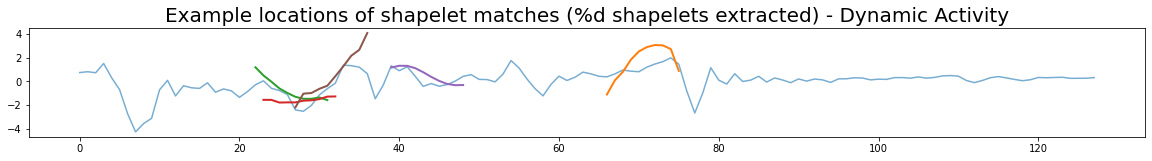

In [78]:
ts_id = 0 # 0 dynamic Activity
plt.figure(figsize=(20,2))
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches "
          "(%d shapelets extracted) - Dynamic Activity".format(n_shapelets), fontsize=20)                         

plt.plot(X_test[ts_id].ravel(), alpha=0.6)
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

#### Shapelets l = 0.08

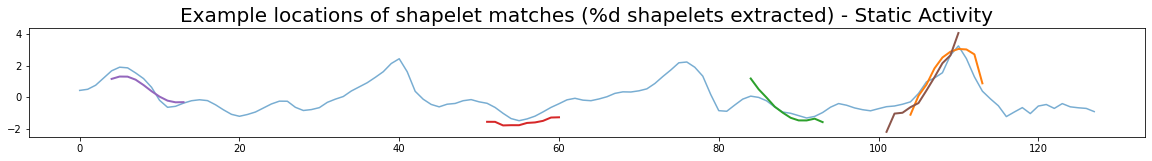

In [79]:
ts_id = 2942 # 1 Dynamic Activity
plt.figure(figsize=(20,2))
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches "
          "(%d shapelets extracted) - Static Activity".format(n_shapelets), fontsize=20)                         

plt.plot(X_test[ts_id].ravel(), alpha=0.6)
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

In [80]:
# 1: Static ,   0: Dynamic
predicted_labels[:5]

array([0, 0, 0, 0, 1], dtype=int64)

In [81]:
y_test[:5]

,Activity
0,0
1,0
2,0
3,0
4,0


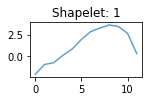

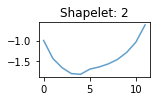

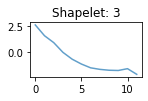

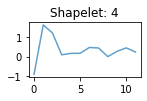

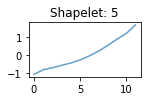

In [46]:
num_shap =[x for x in range(1,6)]
for  shapelet, i in zip(shp_clf.shapelets_, num_shap):
    
    plt.figure(figsize=(2,1))
    plt.title(f"Shapelet: {i}")
    plt.plot(shapelet, alpha=0.7)
    plt.show()

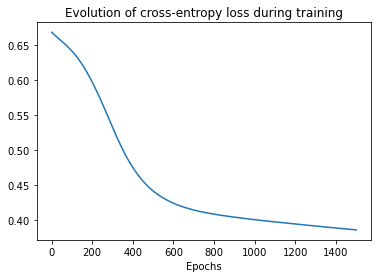

In [83]:
# The loss history is accessible via the `model_` that is a keras model
plt.figure()
plt.plot(np.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"])
plt.title("Evolution of cross-entropy loss during training")
plt.xlabel("Epochs")
plt.show()

# Transform shapelets into a dataset

In [27]:
X_train2= shp_clf.transform(X_train)
X_train2.shape

29/29 [==============================] - 0s 3ms/step


(7352, 5)

In [28]:
X_test2 = shp_clf.transform(X_test)

X_test2.shape


12/12 [==============================] - 0s 3ms/step


(2947, 5)

# Classification with Shapelets

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

## KNN

In [124]:
!pip install pyts

In [30]:
from sklearn.model_selection import GridSearchCV

In [43]:
params = {
         'n_neighbors':[x for x in range(3,25)],
         'weights':['uniform', 'distance'],
         'metric': ['manhattan', 'euclidean']
         }

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, params, verbose=True)
grid.fit(X_train2, y_train)
print(grid.best_params_)

Fitting 5 folds for each of 88 candidates, totalling 440 fits
{'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}


In [44]:
clf = KNeighborsClassifier(n_neighbors=10, weights='uniform', metric='euclidean') 
clf.fit(X_train2, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=10)

In [45]:
y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9619952494061758
F1-score [0.96439924 0.95924309]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1560
           1       0.97      0.95      0.96      1387

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



## DT

In [35]:
params = {
         'max_depth':[x for x in range(3,15)],
         #'min_samples_leaf':[x for x in range(2,30)],
         'min_samples_split': [x for x in range(2,30)],
         'criterion':['gini', 'entropy']
         }
knn = DecisionTreeClassifier()
grid = GridSearchCV(knn, params, verbose=True)
grid.fit(X_train2, y_train)
print(grid.best_params_)

Fitting 5 folds for each of 672 candidates, totalling 3360 fits
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 9}


In [36]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_leaf=8, min_samples_split=2, random_state=42)
clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9562266711910418
F1-score [0.95919013 0.95279912]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1560
           1       0.97      0.94      0.95      1387

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947

